## Data 100 Final Project - COVID19 Dataset

Aislin Liu, Anand Chandra

### Imports

In [24]:
import math
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap 
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.base import clone
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

### The Question

What factors contribute to high numbers per capita of confirmed cases? Which factors are more important to determining per capita confirmed cases and what combination of them provide the best prediction for per capita confirmed cases?

# Data

### Data Processing: Abridged Counties

In this cell, we reformat dates, drop fields we don't find important, and add the field `Hospitals Per Capita`

In [73]:
# Import counties data
abridged_counties = pd.read_csv("abridged_couties.csv")

# Convert the Gregorian dates to UTC timestamp
# Columns that need this: "stay at home", ">50 gatherings", ">500 gatherings", "public schools", "restaurant dine-in", "entertainment/gym", "federal guidelines", "foreign travel ban"
def ordinalToTimeStamp(series):
    arr = []
    array_form = series.values
    for o_date in array_form:
        if not math.isnan(o_date):
            timestamp = pd.Timestamp.fromordinal(int(o_date)).timestamp()
            arr.append(timestamp)
        else:
            arr.append(0)
    return arr
gregorian = ["stay at home", ">50 gatherings", ">500 gatherings", "public schools", "restaurant dine-in", "entertainment/gym", "federal guidelines", "foreign travel ban"]
for column in gregorian:
    abridged_counties[column] = ordinalToTimeStamp(abridged_counties[column])
    
# Drop columns
abridged_counties = abridged_counties.drop(["lat", "lon", "POP_LATITUDE", "POP_LONGITUDE", "CensusRegionName", "CensusDivisionName"], axis=1)

# Hospitals Per Capita
abridged_counties["Hospitals Per Capita"] = abridged_counties["#Hospitals"] / abridged_counties["PopulationEstimate2018"]
abridged_counties.head(10)

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,...,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,Hospitals Per Capita
0,01001,1.0,1.0,Autauga,AL,Alabama,2.0,55601.0,27007.0,28497.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.4354,NaN,NaN,NaN,0.000018
1,01003,1.0,3.0,Baldwin,AL,Alabama,3.0,218022.0,103225.0,109403.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.2162,NaN,NaN,NaN,0.000014
2,01005,1.0,5.0,Barbour,AL,Alabama,6.0,24881.0,13335.0,11935.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.9959,6.08,5400.0,18241.0,0.000040
3,01007,1.0,7.0,Bibb,AL,Alabama,1.0,22400.0,12138.0,10530.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.6003,2.75,14980.0,6120.0,0.000045
4,01009,1.0,9.0,Blount,AL,Alabama,1.0,57840.0,28607.0,29406.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.4242,7.21,31850.0,25233.0,0.000017
5,01011,1.0,11.0,Bullock,AL,Alabama,6.0,10138.0,5615.0,4694.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.8898,2.38,3000.0,7153.0,0.000099
6,01013,1.0,13.0,Butler,AL,Alabama,6.0,19680.0,9232.0,10593.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.8653,1.31,16290.0,3918.0,0.000051
7,01015,1.0,15.0,Calhoun,AL,Alabama,3.0,114277.0,55149.0,59579.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.8252,4.24,35160.0,12712.0,0.000018
8,01017,1.0,17.0,Chambers,AL,Alabama,6.0,33615.0,16140.0,17573.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.7382,NaN,NaN,NaN,0.000000
9,01019,1.0,19.0,Cherokee,AL,Alabama,6.0,26032.0,12846.0,13011.0,...,1.584317e+09,1.584576e+09,1.585354e+09,1.584317e+09,1.583885e+09,0.4516,2.75,15855.0,9610.0,0.000038


### Data Processing: Confirmed

We address null values. In the "Admin2" column, nulls were replaced with empty string for when the data point had no county name stored. All areas/regions that had NaN for "FIPS" column is because they were not an actual county but still a group of people with noteworthy virus infection like correctional facilities. No actual US county has a FIPS of 0 so we filled these nulls in with 0. 

In [74]:
confirmed = pd.read_csv("time_series_covid19_confirmed_US.csv")
print("There are currently " + str(confirmed.isna().sum().sum()) + " NaN values in confirmed")
confirmed["Admin2"].fillna("", inplace=True)
confirmed["FIPS"].fillna(0, inplace=True)
print("There are now " + str(confirmed.isna().sum().sum()) + " NaN values in confirmed")

There are currently 11 NaN values in confirmed
There are now 0 NaN values in confirmed


### New Dataframe: Thresholds

We create a new dataframe that, for each county, contains all features and our y-value: the peak proportion of confirmed cases

In [80]:
# Add some features
population_estimates = abridged_counties[["stay at home", "Smokers_Percentage", 'MedianAge2010', 'countyFIPS', '#Hospitals', 'PopulationEstimate2018', 'RespMortalityRate2014', 'dem_to_rep_ratio', "SVIPercentile", "Hospitals Per Capita"]]

# Drop others
confirmed_modified = confirmed.drop(['iso2', 'iso3', 'code3', 'FIPS', 'Province_State', 'Country_Region', 'Combined_Key', 'Lat', 'Long_'], axis='columns')
confirmed_modified = confirmed_modified[confirmed_modified['Admin2'] != '']
confirmed_modified = confirmed_modified[confirmed_modified['Admin2'] != 'Unassigned']

# Find max percentage
find_max = confirmed_modified.drop(['Admin2'], axis='columns')
find_max = find_max.set_index('UID')
max_vals = find_max.max(axis=1).to_frame()
confirmed_for_thresholds = confirmed[['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Combined_Key']].rename(columns={'FIPS': 'countyFIPS'})
confirmed_for_thresholds['countyFIPS'] = confirmed_for_thresholds['countyFIPS'].astype('int64').astype('str')

# Add field: First confirmed case timestamp
all_date_strings = list(confirmed_modified.drop(['UID', 'Admin2'], axis='columns').columns)
def findFirstTimestamp(data):
    for date_string in all_date_strings:
        if data[date_string] > 0:
            return datetime.strptime(date_string, '%m/%d/%y').timestamp()
confirmed_modified['First Confirmed Case UTC'] = confirmed_modified.apply(lambda data: findFirstTimestamp(data), axis=1)
timestamps = confirmed_modified[['UID', 'First Confirmed Case UTC']]
timestamps = timestamps.set_index('UID')

# Create thresholds
thresholds = confirmed_for_thresholds.merge(population_estimates, on='countyFIPS').dropna()
thresholds = thresholds.merge(max_vals, on='UID')
thresholds = thresholds.rename(columns={0: 'Max_Confirmed'})
thresholds['Max_Percent_Confirmed'] = thresholds['Max_Confirmed'] / thresholds['PopulationEstimate2018']
thresholds = thresholds[thresholds["Max_Percent_Confirmed"] != 0]
thresholds = thresholds.merge(timestamps, on='UID')
thresholds.head(10)

,UID,iso2,iso3,code3,countyFIPS,Admin2,Province_State,Country_Region,Combined_Key,stay at home,...,MedianAge2010,#Hospitals,PopulationEstimate2018,RespMortalityRate2014,dem_to_rep_ratio,SVIPercentile,Hospitals Per Capita,Max_Confirmed,Max_Percent_Confirmed,First Confirmed Case UTC
0,84010001,US,USA,840,10001,Kent,Delaware,US,"Kent, Delaware, US",1.585008e+09,...,36.6,1.0,178550.0,62.05,0.901598,0.7268,0.000006,417,0.002335,1.584515e+09
1,84010003,US,USA,840,10003,New Castle,Delaware,US,"New Castle, Delaware, US",1.585008e+09,...,37.2,2.0,559335.0,49.38,1.904928,0.3761,0.000004,1205,0.002154,1.583910e+09
2,84010005,US,USA,840,10005,Sussex,Delaware,US,"Sussex, Delaware, US",1.585008e+09,...,45.4,3.0,229286.0,50.21,0.628212,0.4019,0.000013,886,0.003864,1.584428e+09
3,84011001,US,USA,840,11001,District of Columbia,District of Columbia,US,"District of Columbia,District of Columbia,US",1.585699e+09,...,33.8,6.0,702455.0,30.21,22.229820,0.5965,0.000009,2666,0.003795,1.584342e+09
4,84012001,US,USA,840,12001,Alachua,Florida,US,"Alachua, Florida, US",1.585094e+09,...,30.1,2.0,269956.0,52.85,1.618909,0.4729,0.000007,215,0.000796,1.583910e+09
5,84012003,US,USA,840,12003,Baker,Florida,US,"Baker, Florida, US",1.585872e+09,...,36.0,1.0,28355.0,97.07,0.205168,0.6803,0.000035,17,0.000600,1.584774e+09
6,84012005,US,USA,840,12005,Bay,Florida,US,"Bay, Florida, US",1.585872e+09,...,39.5,2.0,185287.0,79.48,0.350468,0.6076,0.000011,48,0.000259,1.584774e+09
7,84012007,US,USA,840,12007,Bradford,Florida,US,"Bradford, Florida, US",1.585872e+09,...,39.5,1.0,27732.0,76.84,0.328060,0.9264,0.000036,42,0.001514,1.584860e+09
8,84012009,US,USA,840,12009,Brevard,Florida,US,"Brevard, Florida, US",1.585872e+09,...,45.5,7.0,596849.0,57.16,0.658127,0.3713,0.000012,210,0.000352,1.584428e+09
9,84012011,US,USA,840,12011,Broward,Florida,US,"Broward, Florida, US",1.585267e+09,...,39.7,14.0,1951260.0,39.77,2.120398,0.5844,0.000007,3838,0.001967,1.583568e+09


### Plot Distribution of Peak Confirmed Cases

Text(0.5, 1.0, 'Distribution of the Max Percent of Confirmed Cases')

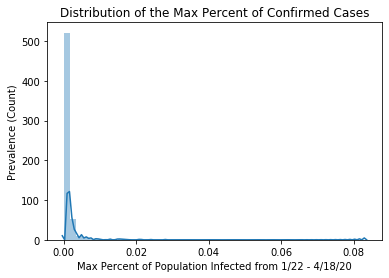

In [81]:
sns.distplot(thresholds["Max_Percent_Confirmed"], norm_hist=False)
plt.ylabel("Prevalence (Count)")
plt.xlabel("Max Percent of Population Infected from 1/22 - 4/18/20")
plt.title("Distribution of the Max Percent of Confirmed Cases")

From this distribution plot of the Max Percent of Population Infected during our time period of interest, 1/22 - 4/18/20, we see a large majority of the values cluster near 0 and are generally very low. This signifies that in calculating error, the values will be numerically low just because of the data values we are working with. We need to evaluate errors from our models while keeping this in mind.

# Feature Selection

### Create Test/Train Sets

In [82]:
train, test = train_test_split(thresholds, test_size=.20, random_state=42)

### Cross Validation Set-Up

This function takes in training data (we will be passing in training data with different features) and calculates the loss

In [83]:
def crossValidateMSE(model, train, y):
    five_fold = KFold(n_splits=5)
    mse_values = []
    for tr_ind, va_ind in five_fold.split(train):
        model.fit(train.iloc[tr_ind, :], y.iloc[tr_ind])
        mse_values.append(mean_squared_error(y.iloc[va_ind], model.predict(train.iloc[va_ind,:])))
    return np.mean(mse_values)


### Import Features

We define the features we plan to use, and exclude the ones that we cannot use (for example, UID or county name)

In [92]:
all_features = list(thresholds.columns)
print(all_features)
usable_features = ["stay at home", "Smokers_Percentage", 'MedianAge2010', 'RespMortalityRate2014', 'dem_to_rep_ratio', 'SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC']
usable_features

['UID', 'iso2', 'iso3', 'code3', 'countyFIPS', 'Admin2', 'Province_State', 'Country_Region', 'Combined_Key', 'stay at home', 'Smokers_Percentage', 'MedianAge2010', '#Hospitals', 'PopulationEstimate2018', 'RespMortalityRate2014', 'dem_to_rep_ratio', 'SVIPercentile', 'Hospitals Per Capita', 'Max_Confirmed', 'Max_Percent_Confirmed', 'First Confirmed Case UTC']


['stay at home',
 'Smokers_Percentage',
 'MedianAge2010',
 'RespMortalityRate2014',
 'dem_to_rep_ratio',
 'SVIPercentile',
 'Hospitals Per Capita',
 'First Confirmed Case UTC']

Below we create some visualizations to get a general overview of the relationships between different features and our Y variable, "Max_Percent_Confirmed". 

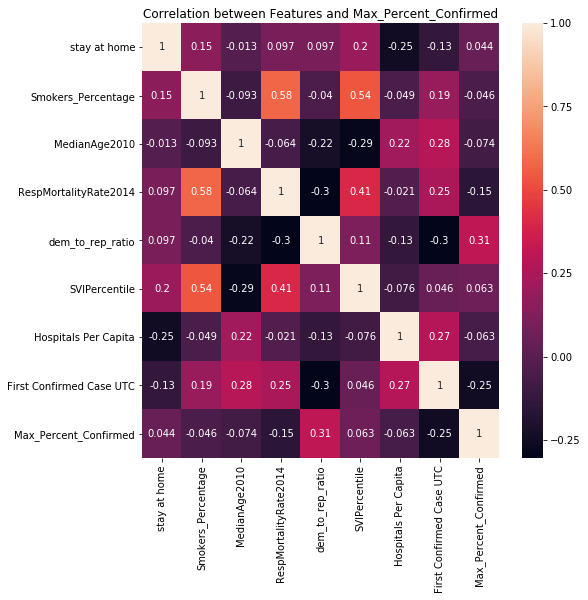

In [85]:
visualization_df = train[usable_features]
visualization_df["Max_Percent_Confirmed"] = train["Max_Percent_Confirmed"]
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(visualization_df.corr(), annot=True)
plt.title("Correlation between Features and Max_Percent_Confirmed")
plt.show()

It appears the features `dem_to_rep_ratio` and `First Confirmed Case UTC` both have strong correlations magnitude-wise and could be good potential indicators for `Max_Percent_Confirmed`. The other features have lower correlations directly with `Max_Percent_Confirmed` but have a high correlation with one of the stronger correlation features like `First Confirmed Case UTC`. 

### Regression Model Selection

We run through different combinations of these features, testing on both `LinearRegression` and `DecisionTreeRegressor` models, and see which ones work best

In [145]:
# Indices of the usable_features
# 0, 1, 2 means we use stay at home, Smokers_Percentage, MedianAge2010
combinations = [
    [0, 1, 2, 3, 4, 5, 6, 7],
    [0, 1, 2, 3, 4],
    [0, 1, 2],
]

#Save losses for visualization purposes
tree_losses = {}
lin_losses = {}

y = train['Max_Percent_Confirmed']
best_combination = 0
min_loss = math.inf
best_model_is_linear = True
for i in range(len(combinations)):
    print('TESTING COMBINATION: {}'.format(i))
    combination = combinations[i]
    features = [usable_features[j] for j in combination]
    training_data = train[features]
    linear_error = crossValidateMSE(LinearRegression(), training_data, y)
    tree_error = crossValidateMSE(tree.DecisionTreeRegressor(), training_data, y)
    tree_losses[i] = tree_error
    lin_losses[i] = linear_error
    loss = min(linear_error, tree_error)
    print('LINEAR ERROR: {}'.format(linear_error))
    print('TREE ERROR: {}'.format(tree_error))
    print()
    #Saving the loss from using all 6 features for use in comparisons later
    if i == 0:
        combo_0_loss_cv = loss
        combo_0_loss_tr = mse(LinearRegression(), training_data, y)
    if loss < min_loss:
        min_loss = loss
        best_combination = i
        best_model_is_linear = linear_error < tree_error

print('SUMMARY')
print('BEST COMBINATION: {} WITH LOSS OF {}'.format(best_combination, min_loss))

TESTING COMBINATION: 0
LINEAR ERROR: 6.991985655093343e-06
TREE ERROR: 8.104840654570258e-06

TESTING COMBINATION: 1
LINEAR ERROR: 7.292744269947612e-06
TREE ERROR: 8.858358278023232e-06

TESTING COMBINATION: 2
LINEAR ERROR: 6.9280826535126255e-06
TREE ERROR: 8.851796042329965e-06

SUMMARY
BEST COMBINATION: 2 WITH LOSS OF 6.9280826535126255e-06


In [137]:
#Function that takes in 2 dictionaries of losses --> loss1, loss2 and names to label plot
def compareModels(loss1, name1, loss2, name2):
    names = list(loss1.keys())
    fig = go.Figure([
        go.Bar(x = names, y = list(loss1.values()), name=name1), 
        go.Bar(x = names, y = list(loss2.values()), name=name2)])
    return fig

fig = compareModels(tree_losses, "dTree CV MSE", lin_losses, "LinReg CV MSE")
fig.update_layout(
    title="Comparison of CV MSE of DecisionTreeRegressor and LinearRegression Models",
    xaxis_title="Feature Combo",
    yaxis_title="CV MSE")
fig.show()

Across different combinations of features we see lower cross-validation error for `LinearRegression` model compared to `DecisionTreeRegressor` model so we proceed to explore optimal feature selection for our `LinearRegression` model.

### Testing Different Feature Combinations

In the cells below we manually sample a combination of (n - 1) features where n = number of usable features we have. We compare their cross validation MSE against cross validation MSE of a model with features used to see which features are more valuable than others.

In [150]:
#dictionaries being filled with key = feature left out, value = resulting mse on this model 
def leastUsefulFeature(usable_features):
    losses_cv = {}
    for feature in usable_features:
        copy = usable_features.copy()
        copy.remove(feature)
        training_data = train[copy]
        cv_linear_error = crossValidateMSE(LinearRegression(), training_data, y)
        losses_cv[feature] = cv_linear_error
    return losses_cv

#Save best CV Loss with one feature missing
losses_cv = leastUsefulFeature(usable_features)
best_loss = (min(losses_cv, key=losses_cv.get), min(list(losses_cv.values())))
print('BEST COMBINATION: LEAVING OUT {} WITH LOSS OF {}'.format(best_loss[0], best_loss[1]))

BEST COMBINATION: LEAVING OUT dem_to_rep_ratio WITH LOSS OF 6.461798239108317e-06


In [151]:
#losses is a dictionary where keys = features of the model, value = mean squared error of the model
all_loss = {}
for feature in usable_features:
    all_loss[feature] = combo_0_loss_cv
    
fig = compareModels(losses_cv, "Left Out Feature", all_loss, "All Features")
fig.update_layout(
    title="Comparison of CV MSE After Leaving Out Single Features",
    xaxis_title="Feature Left Out",
    yaxis_title="CV MSE")
fig.show()

From the visualization above, we can see that certain features are more valuable to the linear regression model than others. It appears that First Confirmed Case UTC is valuable to predicting the Max Percent of Confirmed Cases since error increased when it was left out which makes sense since later first infection dates will have slower growth and have a lower proportion of the infected. Leaving out dem_to_rep_ratio seems to do the most in reducing model error which makes sense since compared to the other features, this one is the least health related though we were curious of the higher proportion of Republicans protesting stay-at-home orders influenced confirmed cases. 

Repeating the process above to visualize and compare all possible combinations of n features would be tedious and inefficient. I found a sklearn tool called `Recursive Feature Elimination` that efficiently takes the number of features you wish to have and recursively selects the best feature for the model until the number of features selected equals the number we indicated we wanted. This tool was used for all possible numbers of features and each optimal combination is output below.

In [152]:
from sklearn.feature_selection import RFE

#prevent mutations to usable_features
copy = usable_features.copy()
copy.remove("dem_to_rep_ratio")
print("Possible Features: ")
print(copy)
print()

#initialize training_data and model
training_data = train[copy]

model = LinearRegression()
best_combos = {}

#iteration through all possible number of features
i = 1
while i < len(copy):
    rfe = RFE(model, i)
    fit = rfe.fit(training_data, y)
    print("Num Features: %d" % fit.n_features_)
    print("Selected Features: ")
    feats = []
    for j in range(len(copy)):
        if fit.ranking_[j] == 1:
            feats.append(copy[j])
    best_combos[i] =  feats
    print(feats)
    print()
    i += 1

Possible Features: 
['stay at home', 'Smokers_Percentage', 'MedianAge2010', 'RespMortalityRate2014', 'SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC']

Num Features: 1
Selected Features: 
['Hospitals Per Capita']

Num Features: 2
Selected Features: 
['SVIPercentile', 'Hospitals Per Capita']

Num Features: 3
Selected Features: 
['RespMortalityRate2014', 'SVIPercentile', 'Hospitals Per Capita']

Num Features: 4
Selected Features: 
['MedianAge2010', 'RespMortalityRate2014', 'SVIPercentile', 'Hospitals Per Capita']

Num Features: 5
Selected Features: 
['Smokers_Percentage', 'MedianAge2010', 'RespMortalityRate2014', 'SVIPercentile', 'Hospitals Per Capita']

Num Features: 6
Selected Features: 
['Smokers_Percentage', 'MedianAge2010', 'RespMortalityRate2014', 'SVIPercentile', 'Hospitals Per Capita', 'First Confirmed Case UTC']



Above are the results of running sklearn's Recursive Feature Elimination tool, with the number of features we want to fit our model to and the combination of highest-ranked features that would produce the "best-fit" model. According to RFE, `stay at home` is not as high ranking of a feature and is never selected. The plot shows the cross validation MSE for each of the best combinations for 1 to (n - 1) features and compares to the best error we got from manually sampling (n - 1) features from the total n features we have to see which performed better. RFE and manual sampling returned different a different set of (n - 1) features so we compare the MSE between the two methods to cross-check.

In [153]:
losses = {}
for combo in best_combos.keys():
    feats = best_combos[combo]
    training_data = train[feats]
    cv_linear_error = crossValidateMSE(LinearRegression(), training_data, y)
    losses[combo] = cv_linear_error


fig = compareModels(losses, "CV MSE", {}, "")
fig.add_trace(go.Scatter(
    x=list(best_combos.keys()),
    y=[best_loss[1] for _ in list(losses.keys())],
    name="Best CV MSE from Manual Combo Selection"
))
fig.update_layout(
    title="Comparison of CV MSE Over All Best Feature Combos Found From RFE",
    xaxis_title="Best Feature Combination for n Features",
    yaxis_title="CV MSE")
fig.show()

In [154]:
best_features = best_combos[min(losses, key = losses.get)]
print("THE BEST FEATURES FOR OUR ")

['Smokers_Percentage',
 'MedianAge2010',
 'RespMortalityRate2014',
 'SVIPercentile',
 'Hospitals Per Capita',
 'First Confirmed Case UTC']

In [ ]:
#once finalized model, train on test data and plot results

In [8]:
def mse(model, train, y):
    model.fit(train, y)
    return mean_squared_error(y, model.predict(train))